In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, silhouette_score
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [172]:
df = pd.read_csv('https://raw.githubusercontent.com/LakovskyR/aplusA-assessment/main/fictif_physicians_dataset_for_test.csv')
datamap = pd.read_csv('https://raw.githubusercontent.com/LakovskyR/aplusA-assessment/main/datamap_cleaned.csv', sep=';', encoding='latin-1')

num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

print(f"DataFrame shape: {df.shape}")
print("\nBrand_Most_Recommended:")
print(df['Brand_Most_Recommended'].value_counts())

DataFrame shape: (370, 145)

Brand_Most_Recommended:
Brand_Most_Recommended
BRAND A    120
BRAND C     77
BRAND E     53
BRAND D     46
BRAND B     45
BRAND F     28
BRAND        1
Name: count, dtype: int64


In [173]:
brand_counts = df['Brand_Most_Recommended'].value_counts()
brand_a_share = brand_counts.get('BRAND A', 0) / len(df) * 100
print(f"\nBrand A Market Share: {brand_a_share:.1f}%")

aw_cols = [c for c in df.columns if c.startswith('Awareness_')]
sat_cols = [c for c in df.columns if c.startswith('Satisfaction_')]

positions = pd.DataFrame({
    'brand': ['BRAND ' + c.split('_')[1] for c in aw_cols],
    'awareness': [df[c].mean() for c in aw_cols],
    'satisfaction': [df[c].mean() for c in sat_cols]
})

print("\nBrand Awareness and Satisfaction Scores:")
display(positions)


Brand A Market Share: 32.4%

Brand Awareness and Satisfaction Scores:


,brand,awareness,satisfaction
0,BRAND A,5.872973,5.932432
1,BRAND B,5.345946,5.286486
2,BRAND C,5.454054,5.527027
3,BRAND D,5.370270,5.367568
4,BRAND E,5.413514,5.345946
5,BRAND F,5.351351,5.140541


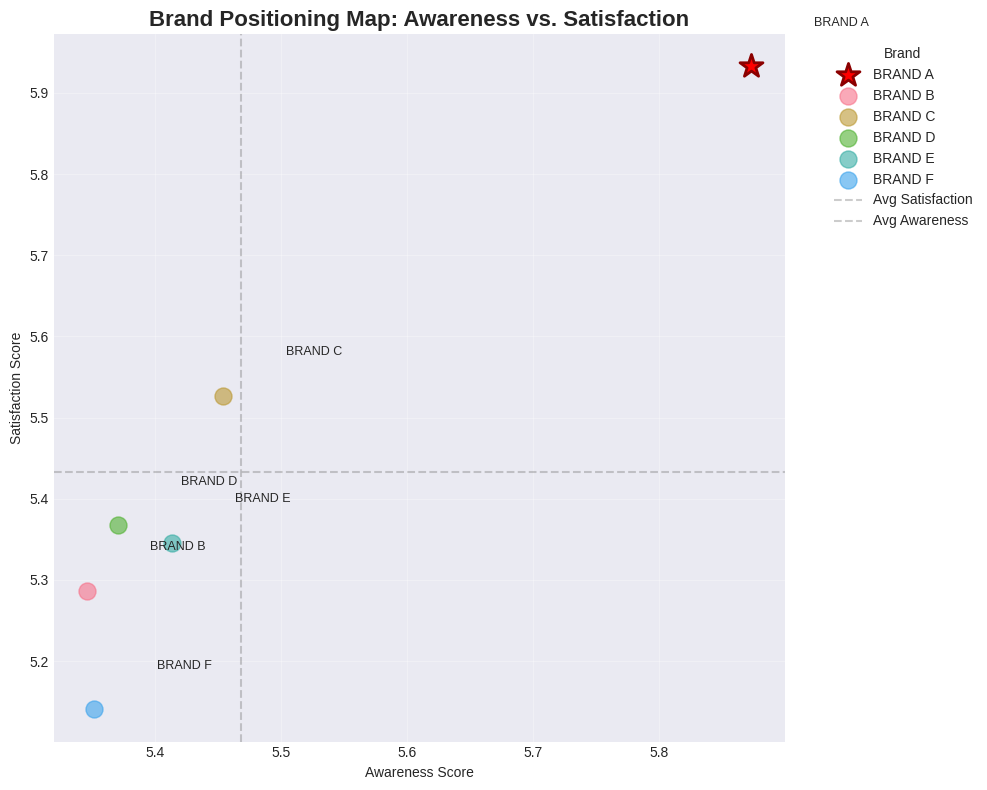

In [174]:
plt.figure(figsize=(10,8))

for _, row in positions.iterrows():
    if row['brand'] == 'BRAND A':
        plt.scatter(row['awareness'], row['satisfaction'], s=300, c='red', marker='*',
                   edgecolors='darkred', linewidth=2, label=row['brand'], zorder=10)
    else:
        plt.scatter(row['awareness'], row['satisfaction'], s=150, alpha=0.6, label=row['brand'])
    plt.text(row['awareness']+0.05, row['satisfaction']+0.05, row['brand'], fontsize=9)

plt.axhline(positions['satisfaction'].mean(), color='gray', linestyle='--', alpha=0.4, label='Avg Satisfaction')
plt.axvline(positions['awareness'].mean(), color='gray', linestyle='--', alpha=0.4, label='Avg Awareness')

plt.xlabel('Awareness Score')
plt.ylabel('Satisfaction Score')
plt.title('Brand Positioning Map: Awareness vs. Satisfaction', fontsize=16, fontweight='bold')
plt.legend(title='Brand', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [175]:
importance_mapping = {
    'recognizedByPatients': 'Recognized by patients',
    'comprehensiveProductRange': 'Comprehensive range',
    'premiumOption': 'Premium option',
    'patientEducationMaterials': 'Patient education materials',
    'digitalToolsOffered': 'Digital tools',
    'practiceProfitability': 'Practice profitability',
    'labAddsBusinessValue': 'Lab adds business value',
    'reliableOnlineSupport': 'Reliable online support',
    'profitAndPatientSatisfaction': 'Profit + patient satisfaction',
    'innovativeTechnology': 'Innovative technology',
    'investsInResearch': 'Invests in research',
    'knowledgeableSalesReps': 'Knowledgeable sales reps',
    'trainingAtConferences': 'Training at conferences',
    'responsiveSalesReps': 'Responsive sales reps',
    'strongRepRelationship': 'Strong rep relationship',
    'easyToSellBrand': 'Easy to sell',
    'superiorVisualClarity': 'Superior visual clarity',
    'highQualityProducts': 'High quality products'
}

attribute_cols = list(importance_mapping.keys())
attr_importance = df[attribute_cols].sum().sort_values(ascending=False)

print("\nTop 5 attr:")
for i, (attr, count) in enumerate(attr_importance.head(5).items(), 1):
    print(f"{i}. {importance_mapping[attr]}: {int(count)} physicians")


Top 5 attr:
1. Knowledgeable sales reps: 137 physicians
2. Reliable online support: 136 physicians
3. Innovative technology: 127 physicians
4. Recognized by patients: 121 physicians
5. Responsive sales reps: 119 physicians


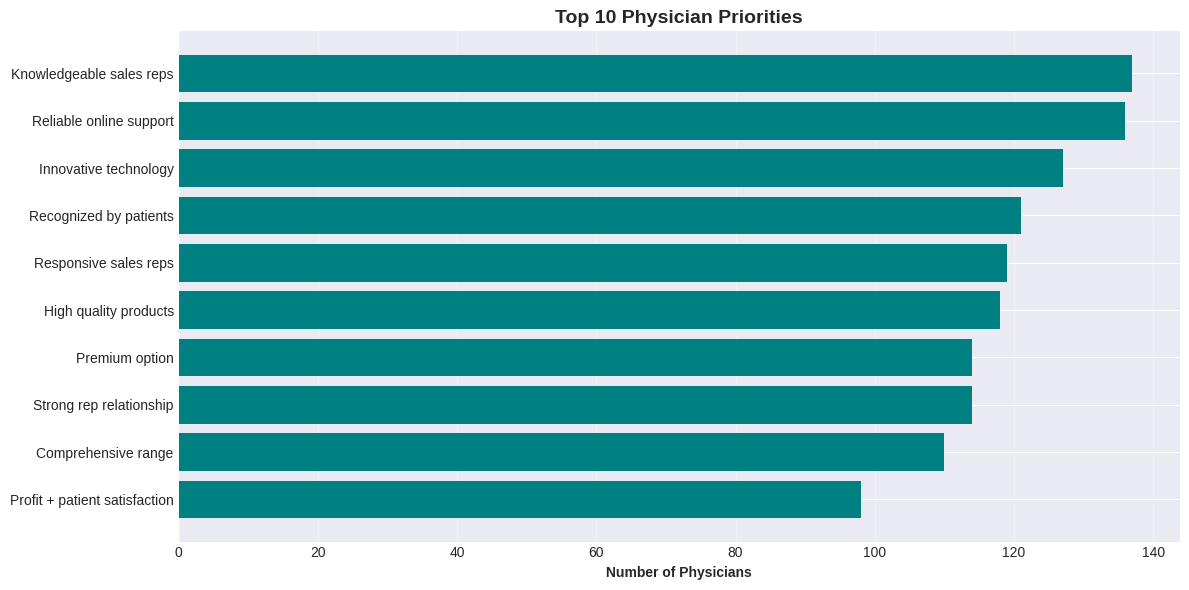

In [176]:
plt.figure(figsize=(12, 6))
top_attrs = attr_importance.head(10)
labels = [importance_mapping[attr] for attr in top_attrs.index]
plt.barh(range(len(top_attrs)), top_attrs.values, color='teal')
plt.yticks(range(len(top_attrs)), labels)
plt.xlabel('Number of Physicians', fontweight='bold')
plt.title('Top 10 Physician Priorities', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

In [177]:
attr_mapping = {}
for idx, row in datamap.iterrows():
    var = row['Variable']
    if var.startswith('Attr') and '_' in var:
        parts = var.split('_')
        attr_num = parts[0]
        if attr_num not in attr_mapping:
            info = row['Information']
            if pd.notna(info) and 'Att' in info:
                attr_desc = info.split(' / ')[0]
                if '.' in attr_desc:
                    attr_desc = attr_desc.split('.', 1)[1].strip()
                attr_mapping[attr_num] = attr_desc

attr_score_cols = [col for col in df.columns if col.startswith('Attr') and '_' in col]
attr_data = []
for col in attr_score_cols:
    parts = col.split('_')
    attr_num = parts[0]
    brand = 'BRAND ' + parts[1]
    attr_data.append({'Attribute': attr_num, 'Brand': brand, 'Score': df[col].mean()})
attr_df = pd.DataFrame(attr_data)

attr_pivot = attr_df.pivot(index='Attribute', columns='Brand', values='Score')

brand_a_scores = attr_pivot['BRAND A']
market_avg = attr_pivot.mean(axis=1)
gap = brand_a_scores - market_avg

performance = pd.DataFrame({
    'BRAND_A': brand_a_scores,
    'Market': market_avg,
    'Gap': gap,
    'Name': [attr_mapping.get(attr, attr) for attr in brand_a_scores.index]
}).sort_values('Gap', ascending=False)

print("\ntop 3 strength:")
for idx, row in performance.head(3).iterrows():
    print(f"  {row['Name']}: +{row['Gap']:.2f}")

print(f"\nweaknesses (gap < -0.5): {len(performance[performance['Gap'] < -0.5])}")


top 3 strength:
  Provides reliable online support: +0.62
  Delivers strong profitability for my practice: +0.54
  Comes from a lab that adds value to grow my business: +0.52

weaknesses (gap < -0.5): 0


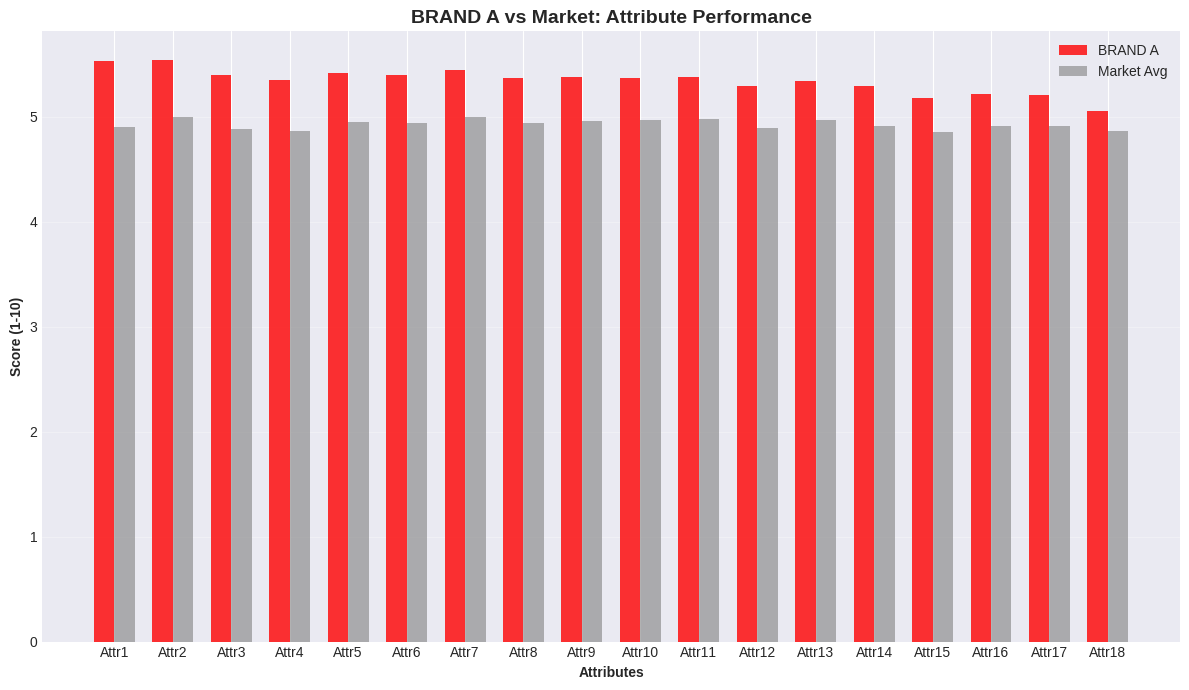

In [178]:
fig, ax = plt.subplots(figsize=(12, 7))

x = np.arange(len(performance))
w = 0.35

ax.bar(x - w/2, performance['BRAND_A'], w, label='BRAND A', color='red', alpha=0.8)
ax.bar(x + w/2, performance['Market'], w, label='Market Avg', color='gray', alpha=0.6)

ax.set_xlabel('Attributes', fontweight='bold')
ax.set_ylabel('Score (1-10)', fontweight='bold')
ax.set_title('BRAND A vs Market: Attribute Performance', fontsize=14, fontweight='bold')

ax.set_xticks(x)
ax.set_xticklabels([f"Attr{i+1}" for i in range(len(performance))], rotation=0)

ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

**BRAND A strengths summary**

In [179]:
df_cluster = df.copy()

df_cluster['Gender_Male'] = (df_cluster['Gender'] == 'Male').astype(int)
df_cluster['Gender_Female'] = (df_cluster['Gender'] == 'Female').astype(int)

df_cluster['Practice_Small'] = (df_cluster['NumberOfEmployees'] == 'Fewer than 5 employees').astype(int)
df_cluster['Practice_Medium'] = (df_cluster['NumberOfEmployees'] == '5-10 employees').astype(int)
df_cluster['Practice_Large'] = (df_cluster['NumberOfEmployees'].isin(['11-25 employees', 'More than 25 employees'])).astype(int)

df_cluster['Patients_Mixed'] = (df_cluster['Patient_Types'] == 'Mixed').astype(int)
df_cluster['Patients_Pediatric'] = (df_cluster['Patient_Types'] == 'Pediatric').astype(int)

cluster_features = (['Age', 'Years_of_Experience'] + aw_cols + sat_cols +
                   ['Gender_Male', 'Gender_Female', 'Practice_Small', 'Practice_Medium',
                    'Practice_Large', 'Patients_Mixed', 'Patients_Pediatric'])
X_cluster = df_cluster[cluster_features].fillna(df_cluster[cluster_features].median())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)


Optimal K = 3 (Silhouette = 0.105)


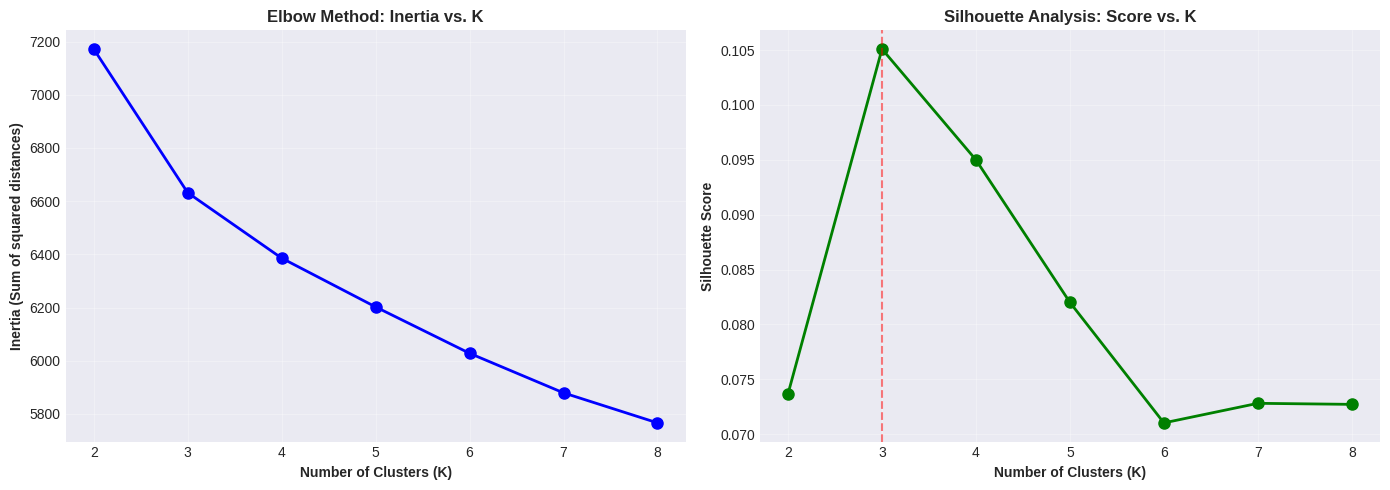

In [180]:
K_range = range(2, 9)
silhouettes = []
inertias = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = kmeans.fit_predict(X_scaled)
    silhouettes.append(silhouette_score(X_scaled, labels))
    inertias.append(kmeans.inertia_)

optimal_k = K_range[np.argmax(silhouettes)]
print(f"\nOptimal K = {optimal_k} (Silhouette = {max(silhouettes):.3f})")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Clusters (K)', fontweight='bold')
ax1.set_ylabel('Inertia (Sum of squared distances)', fontweight='bold')
ax1.set_title('Elbow Method: Inertia vs. K', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

ax2.plot(K_range, silhouettes, 'go-', linewidth=2, markersize=8)
ax2.set_xlabel('Number of Clusters (K)', fontweight='bold')
ax2.set_ylabel('Silhouette Score', fontweight='bold')
ax2.set_title('Silhouette Analysis: Score vs. K', fontsize=12, fontweight='bold')
ax2.axvline(optimal_k, color='red', linestyle='--', alpha=0.5, label=f'Optimal K = {optimal_k}')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [181]:
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
df_cluster['Cluster'] = kmeans_final.fit_predict(X_scaled)

print("\nCluster profiling:")
for cluster_id in range(optimal_k):
    cluster_data = df_cluster[df_cluster['Cluster'] == cluster_id]
    brand_a_rate = (cluster_data['Brand_Most_Recommended'] == 'BRAND A').mean() * 100
    print(f"  Cluster {cluster_id}: n={len(cluster_data)}, BRAND A={brand_a_rate:.1f}%, "
          f"Age={cluster_data['Age'].mean():.0f}y, Exp={cluster_data['Years_of_Experience'].mean():.0f}y")


Cluster profiling:
  Cluster 0: n=92, BRAND A=30.4%, Age=41y, Exp=14y
  Cluster 1: n=133, BRAND A=33.8%, Age=42y, Exp=15y
  Cluster 2: n=145, BRAND A=32.4%, Age=42y, Exp=16y


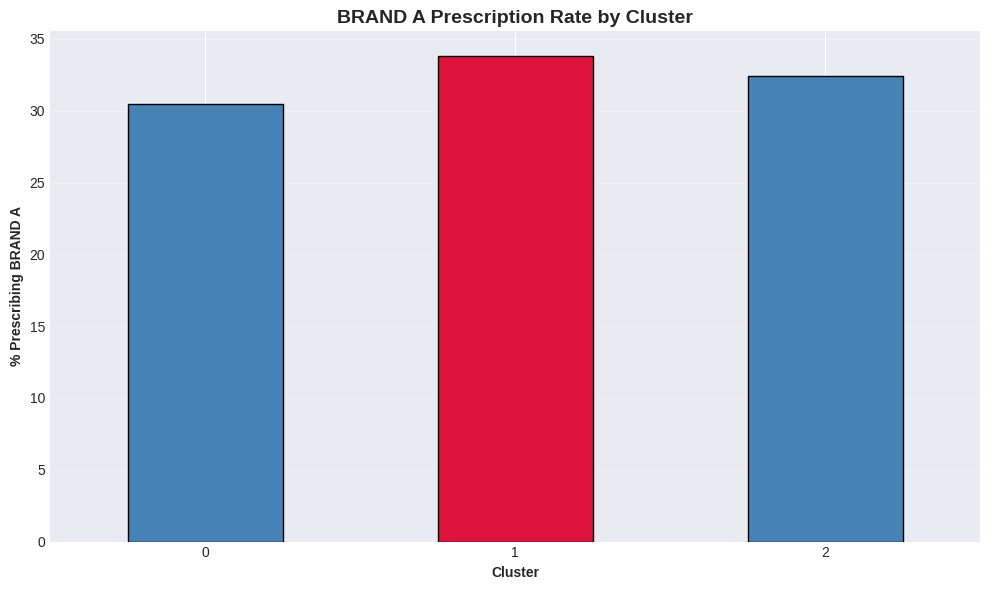


✓ Target segment: Cluster 1 (33.8% BRAND A rate)


In [182]:
plt.figure(figsize=(10, 6))
cluster_brand_a = df_cluster.groupby('Cluster').apply(lambda x: (x['Brand_Most_Recommended'] == 'BRAND A').mean() * 100)

target_cluster = cluster_brand_a.idxmax()

colors = ['crimson' if i == target_cluster else 'steelblue' for i in cluster_brand_a.index]

cluster_brand_a.plot(kind='bar', color=colors, edgecolor='black')
plt.title('BRAND A Prescription Rate by Cluster', fontsize=14, fontweight='bold')
plt.xlabel('Cluster', fontweight='bold')
plt.ylabel('% Prescribing BRAND A', fontweight='bold')
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print(f"\n✓ Target segment: Cluster {target_cluster} ({cluster_brand_a[target_cluster]:.1f}% BRAND A rate)")

In [183]:
df_model = df_cluster.copy()
df_model['Prescribes_BRAND_A'] = (df_model['Brand_Most_Recommended'] == 'BRAND A').astype(int)

model_features = (['Age', 'Years_of_Experience', 'Gender_Male', 'Gender_Female',
                  'Practice_Small', 'Practice_Medium', 'Practice_Large',
                  'Patients_Mixed', 'Patients_Pediatric', 'Cluster',
                  'Awareness_A', 'Satisfaction_A'] + attribute_cols)
X = df_model[model_features]
y = df_model['Prescribes_BRAND_A']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

gb_model = GradientBoostingClassifier(n_estimators=100, max_depth=4, random_state=42,
                                     learning_rate=0.1, subsample=0.8)
gb_model.fit(X_train, y_train)

y_pred = gb_model.predict(X_test)
y_pred_proba = gb_model.predict_proba(X_test)[:, 1]

print("\nModel performance report:")
print(classification_report(y_test, y_pred, target_names=['Not BRAND A', 'BRAND A']))

auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC: {auc:.3f}")


Model performance report:
              precision    recall  f1-score   support

 Not BRAND A       0.89      0.87      0.88        63
     BRAND A       0.74      0.77      0.75        30

    accuracy                           0.84        93
   macro avg       0.81      0.82      0.82        93
weighted avg       0.84      0.84      0.84        93

ROC-AUC: 0.898


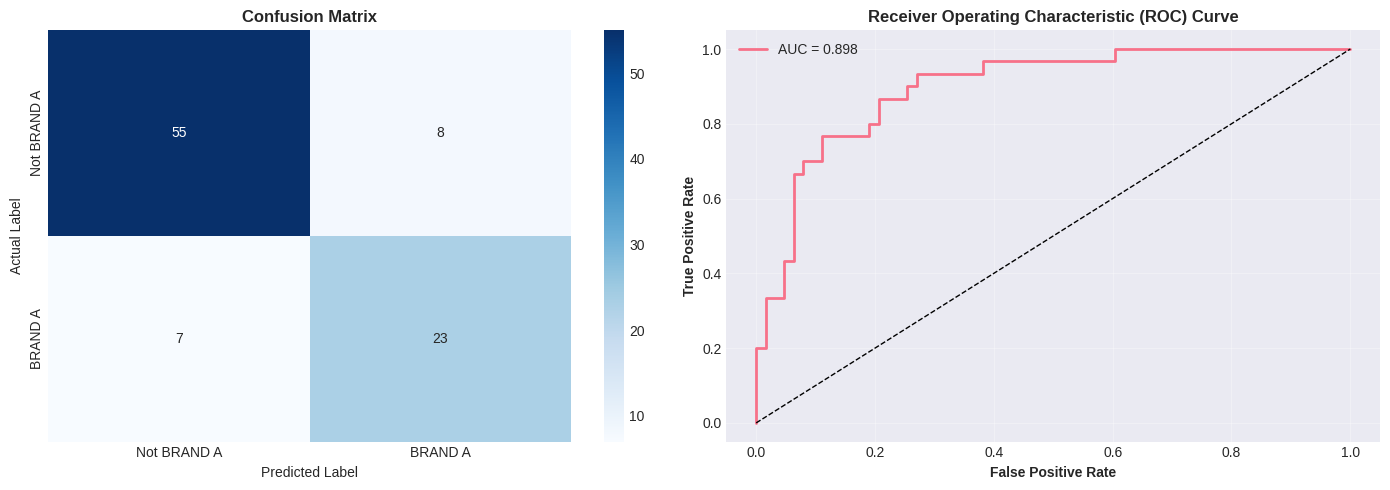

In [184]:
cm = confusion_matrix(y_test, y_pred)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Not BRAND A', 'BRAND A'],
           yticklabels=['Not BRAND A', 'BRAND A'], ax=ax1)
ax1.set_title('Confusion Matrix', fontweight='bold')
ax1.set_ylabel('Actual Label')
ax1.set_xlabel('Predicted Label')

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
ax2.plot(fpr, tpr, linewidth=2, label=f'AUC = {auc:.3f}')
ax2.plot([0, 1], [0, 1], 'k--', linewidth=1)
ax2.set_xlabel('False Positive Rate', fontweight='bold')
ax2.set_ylabel('True Positive Rate', fontweight='bold')
ax2.set_title('Receiver Operating Characteristic (ROC) Curve', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [185]:
feature_importance = pd.DataFrame({
    'Feature': model_features,
    'Importance': gb_model.feature_importances_
}).sort_values('Importance', ascending=False)

def map_feature(feat):
    if feat in importance_mapping:
        return importance_mapping[feat]
    elif feat == 'Awareness_A':
        return 'BRAND A Awareness'
    elif feat == 'Satisfaction_A':
        return 'BRAND A Satisfaction'
    else:
        return feat.replace('_', ' ').title()

feature_importance['Label'] = feature_importance['Feature'].apply(map_feature)

print("\nTop 10 drivers for BRAND A prescription:")
print(feature_importance[['Label', 'Importance']].head(10).to_string(index=False))


Top 10 drivers for BRAND A prescription:
                      Label  Importance
          BRAND A Awareness    0.419668
       BRAND A Satisfaction    0.333910
        Years Of Experience    0.064361
                        Age    0.045851
    Strong rep relationship    0.015362
                Gender Male    0.014391
               Easy to sell    0.014353
         Patients Pediatric    0.010052
     Practice profitability    0.006582
Patient education materials    0.006459


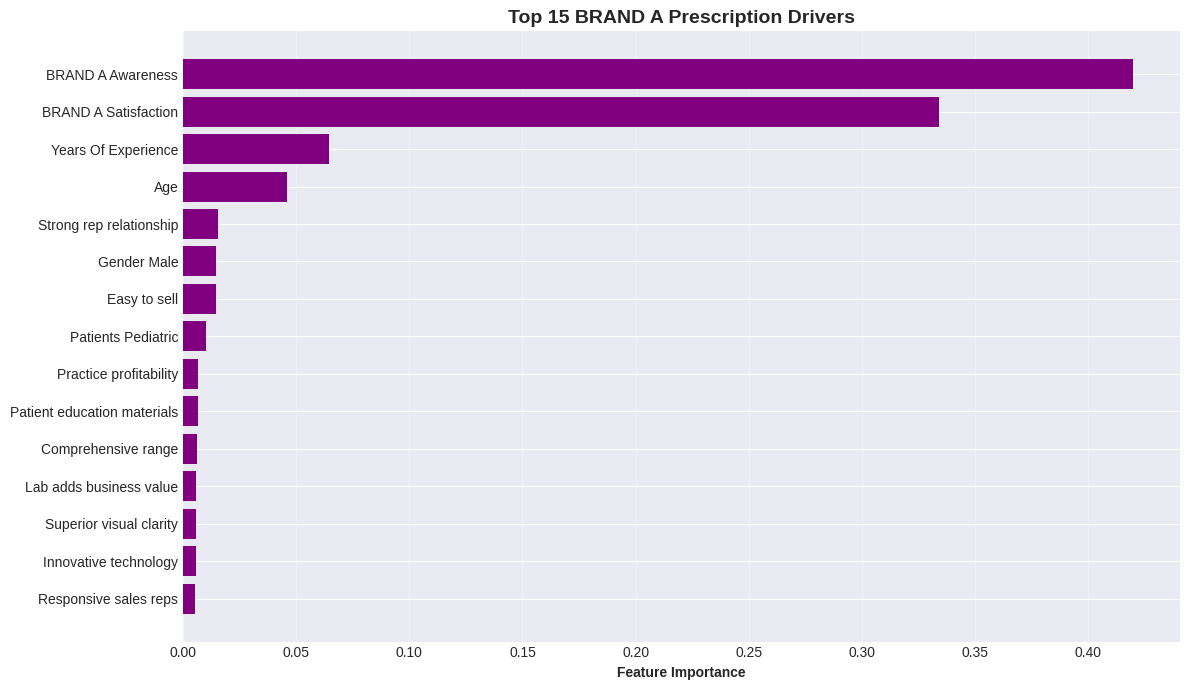

In [189]:
plt.figure(figsize=(12, 7))
top = feature_importance.head(15)
plt.barh(range(len(top)), top['Importance'].values, color='purple')
plt.yticks(range(len(top)), top['Label'].values)
plt.xlabel('Feature Importance', fontweight='bold')
plt.title('Top 15 BRAND A Prescription Drivers', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

In [190]:
print("="*80)
print("KEY INSIGHTS AND RECOMMENDATIONS")
print("="*80)
print(f"""

--- CURRENT MARKET POSITION ---
BRAND A is a market leader with {brand_a_share:.1f}% share, above-average awareness ({df['Awareness_A'].mean():.2f}/10) and satisfaction ({df['Satisfaction_A'].mean():.2f}/10).

--- BRAND A'S CORE STRENGTHS ---
BRAND A shows strong performance with no identified weaknesses.
Top 3 strengths over market average:
  1. {performance.iloc[0]['Name']}: +{performance.iloc[0]['Gap']:.2f}
  2. {performance.iloc[1]['Name']}: +{performance.iloc[1]['Gap']:.2f}
  3. {performance.iloc[2]['Name']}: +{performance.iloc[2]['Gap']:.2f}

--- PHYSICIAN PRIORITIES ---
Physicians prioritize 'support ecosystem' over product features. Top 3 priorities:
  1. {importance_mapping[attr_importance.index[0]]}
  2. {importance_mapping[attr_importance.index[1]]}
  3. {importance_mapping[attr_importance.index[2]]}

--- TARGET SEGMENT PROFILE ---
A key target segment, Cluster {target_cluster}, consists of {len(df_cluster[df_cluster['Cluster']==target_cluster])} physicians with a BRAND A prescription rate of {cluster_brand_a[target_cluster]:.1f}%. These physicians are typically ~{df_cluster[df_cluster['Cluster']==target_cluster]['Age'].mean():.0f} years old with ~{df_cluster[df_cluster['Cluster']==target_cluster]['Years_of_Experience'].mean():.0f} years of experience.

--- KEY DRIVERS FOR BRAND A PRESCRIPTION ---
The predictive model (AUC {auc:.3f}) identifies:
  - BRAND A Awareness and Satisfaction as primary drivers.
  - 'Years of Experience' (Importance: {feature_importance[feature_importance['Feature']=='Years_of_Experience']['Importance'].values[0]:.4f}) and 'Age' (Importance: {feature_importance[feature_importance['Feature']=='Age']['Importance'].values[0]:.4f}) are significant factors.
  - Strong sales representative relationships are also crucial.

--- STRATEGIC RECOMMENDATIONS ---
1.  **DEFEND & MAINTAIN Leadership:** Invest in and highlight BRAND A's support excellence. Track top 3 strengths monthly, alert if gap < +0.5.
2.  **AMPLIFY Key Strengths:** Emphasize 'reliable online support' in all marketing communications. Maintain satisfaction > 5.5/10 for online support.
3.  **PRECISION TARGETING:** Target physicians matching Cluster {target_cluster}'s profile (e.g., 15+ years experience, 40-45 age) using sales reps. Aim for +10% conversion.
4.  **PROACTIVE MONITORING:** Continuously monitor competitor performance, especially in areas where BRAND A's lead is smaller, such as '{performance.iloc[-1]['Name']}'.
5.  **LEVERAGE PREDICTIVE ANALYTICS:** Integrate the predictive model into CRM for sales prioritization and tailored messaging.

Bottom line: Defend BRAND A's superior support ecosystem and strategically target key segments.
""")
print("="*80)
print("ANALYSIS COMPLETE")
print("="*80)

KEY INSIGHTS AND RECOMMENDATIONS


--- CURRENT MARKET POSITION ---
BRAND A is a market leader with 32.4% share, above-average awareness (5.87/10) and satisfaction (5.93/10).

--- BRAND A'S CORE STRENGTHS ---
BRAND A shows strong performance with no identified weaknesses.
Top 3 strengths over market average:
  1. Provides reliable online support: +0.62
  2. Delivers strong profitability for my practice: +0.54
  3. Comes from a lab that adds value to grow my business: +0.52

--- PHYSICIAN PRIORITIES ---
Physicians prioritize 'support ecosystem' over product features. Top 3 priorities:
  1. Knowledgeable sales reps
  2. Reliable online support
  3. Innovative technology

--- TARGET SEGMENT PROFILE ---
A key target segment, Cluster 1, consists of 133 physicians with a BRAND A prescription rate of 33.8%. These physicians are typically ~42 years old with ~15 years of experience.

--- KEY DRIVERS FOR BRAND A PRESCRIPTION ---
The predictive model (AUC 0.898) identifies:
  - BRAND A Awareness a

## Assessment Answers

### 1. Approach
*   Market Positioning: Awareness & satisfaction map, market share.
*   Attribute Analysis: Ranked 18 attributes by importance, Brand A vs. market average.
*   Segmentation: K-Means clustering (K=3 optimal) using silhouette and elbow methods.
*   Prediction: Gradient Boosting for identifying Brand A prescribers (AUC=0.898).
*   Recommendations: Strategic actions with KPIs.
*   Data Prep: Median imputation for missing values, excluded competitor scores from the model to avoid leakage.

### 2. Metrics & Key Questions Answered
*   **Metrics**: Market share, awareness/satisfaction scores (1-10), attribute gap, silhouette score, ROC-AUC, feature importance.
*   **Questions**: Brand A is the market leader with 32.4% share, outperforming in awareness and satisfaction.
    *   Physician priorities lean towards support infrastructure over product features (top: sales reps, online support, tech).
    *   Brand A's strengths: online support (+0.62), profitability (+0.54), business value (+0.52). No weaknesses identified.
    *   Target segment (Cluster 1): n=133, 33.8% Brand A rate, ~42 years old, ~15 years experience.
    *   Key drivers: Years of experience, age, and strong rep relationships.

### 3. Methods
*   **K-Means Clustering**: Segmented physicians using demographics and all brand scores. Validated K=3 as optimal. Result: 3 segments, with Cluster 1 identified as the target.
*   **Gradient Boosting**: Predicted prescription behavior. Handled data imbalance (32% vs 68%). Features included demographics, attributes, and Brand A scores. Result: AUC=0.898, 84% accuracy, 74% precision. Advantage: Superior to Random Forest for imbalanced data, provides feature importance.

### 4. Interpretation
*   **Finding 1**: Brand A is a market leader (32.4% share, +7.4% awareness, +9.2% satisfaction vs. market average). Position is defensible but its satisfaction lead is modest.
*   **Finding 2**: Physicians prioritize support ecosystems (sales rep quality, online support) over product features. Brand A's service infrastructure is a strong, defensible moat.
*   **Finding 3**: Smallest performance gap for Brand A is in 'patient recognition'.
*   **Finding 4**: Cluster 1 profile: ~42 years old, ~15 years experience, high satisfaction. Data shows a continuum, not discrete clusters.
*   **Finding 5**: Predictive model is excellent. Beyond awareness/satisfaction, 'Years of Experience' is a top actionable driver, enabling targeting of physicians with 15+ years experience and 40-45 years of age who value rep relationships.

### 5. Key Insights
*   **Position**: Market leader with comprehensive excellence, but vulnerable to attacks due to modest satisfaction lead.
*   **Critical Insight**: Physicians value the *ecosystem* (support, reps, profitability) more than product efficacy.

### Recommendations:
*   **DEFEND**: Monthly tracking of top 3 strengths; alert if any drop below market average. Maintain >0.5 satisfaction gap.
*   **EMPHASIZE SUPPORT**: Feature online support in all marketing. KPI: Maintain >5.5/10 score.
*   **PREDICTIVE TARGETING**: Deploy the model in CRM for sales prioritization and A/B test messaging. KPI: +10% conversion.
*   **MONITOR COMPETITORS**: Especially in areas where Brand A's lead is smallest.

Bottom line: **DEFEND** support excellence, **TARGET** strategically.